In [124]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import sklearn
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, LinearRegression, HuberRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics

import itertools
import pickle
from tqdm import tqdm

from datetime import datetime
from datetime import timedelta

import optuna
import pickle
import joblib
import xgboost



In [125]:
n_jobs = 14 

In [126]:
df_train = pd.read_csv('/storage/tartar/mborisov/train_classic_full.csv', sep=',', decimal='.', parse_dates=['photo_datetime', 'radiation_datetime'])
df_test = pd.read_csv('/storage/tartar/mborisov/test_classic_full.csv', sep=',', decimal='.', parse_dates=['photo_datetime', 'radiation_datetime'])
#df_train.shape, df_test.shape
df_train['sin_sun'] = np.sin(np.radians(df_train['sun_altitude'].values))
df_test['sin_sun'] = np.sin(np.radians(df_test['sun_altitude'].values))
df_train['date_hour'] = pd.to_datetime(df_train['photo_datetime'].dt.date) + \
           pd.to_timedelta(df_train['photo_datetime'].dt.hour, unit='hours')
df_test['date_hour'] = pd.to_datetime(df_test['photo_datetime'].dt.date) + \
           pd.to_timedelta(df_test['photo_datetime'].dt.hour, unit='hours')
df_full = pd.concat((df_train, df_test))
df_full['date_hour'] = pd.to_datetime(df_full['photo_datetime'].dt.date) + \
           pd.to_timedelta(df_full['photo_datetime'].dt.hour, unit='hours')
df_full.head()

,photo_name,photo_datetime,CM3up[W/m2],CG3up[W/m2],CM3down[W/m2],CG3down[W/m2],radiation_datetime,feature0,feature1,feature2,...,feature159,feature160,feature161,date-hour,datetime_UTC,lat,lon,sun_altitude,sin_sun,date_hour
0,img-2014-09-17T10-00-43devID1.jpg,2014-09-17 10:00:43,158.833993,-91.263207,39.045110,-2.084933,2014-09-17 10:00:44,97.094520,1751.681381,255.0,...,0.538882,0.722970,0.973412,2014-09-17-10,2014-09-17 10:00:43.290268,66.583405,-29.273292,14.318959,0.247320,2014-09-17 10:00:00
1,img-2014-09-17T10-00-44devID2.jpg,2014-09-17 10:00:44,158.833993,-91.263207,39.045110,-2.084933,2014-09-17 10:00:44,107.922526,1848.315610,255.0,...,0.553206,0.722807,0.973412,2014-09-17-10,2014-09-17 10:00:43.290268,66.583405,-29.273292,14.318959,0.247320,2014-09-17 10:00:00
2,img-2014-09-17T10-01-43devID1.jpg,2014-09-17 10:01:43,149.357024,-88.420117,34.590935,0.189539,2014-09-17 10:01:44,96.720268,1685.916556,255.0,...,0.538814,0.703659,0.973412,2014-09-17-10,2014-09-17 10:01:43.301701,66.583967,-29.276475,14.403886,0.248756,2014-09-17 10:00:00
3,img-2014-09-17T10-01-44devID2.jpg,2014-09-17 10:01:44,149.357024,-88.420117,34.590935,0.189539,2014-09-17 10:01:44,107.917577,1830.592868,255.0,...,0.554802,0.722170,0.973412,2014-09-17-10,2014-09-17 10:01:43.301701,66.583967,-29.276475,14.403886,0.248756,2014-09-17 10:00:00
4,img-2014-09-17T10-02-43devID1.jpg,2014-09-17 10:02:43,143.102225,-88.135807,36.391559,0.473848,2014-09-17 10:02:44,96.890459,1671.656306,255.0,...,0.543301,0.702826,0.973412,2014-09-17-10,2014-09-17 10:02:43.303133,66.584686,-29.280270,14.488320,0.250183,2014-09-17 10:00:00


df_test_small = df_test[::5]
mae_array = np.array(0)

In [127]:
def calculate_weights_with_alfa(target: np.ndarray, alfa: float):
    perc = np.percentile(target, np.arange(0, 101))
    di = perc[1:] - perc[:-1]
    wi = (di)/np.mean(di)
    weights_with_alfa = (wi-1)*alfa+1
    weight_index = np.searchsorted(di, target, side='left') - 1
    complex_weights = weights_with_alfa[weight_index]
    return complex_weights


def create_Xy(df_train):
    feature_columns = [c for c in df_train.columns if c.startswith('f') or c=='sin_sun']    
    ytr = df_train['CM3up[W/m2]'].values
    Xtr = df_train[feature_columns].values
    #print('dataset_features: ' + str(Xtr.shape) + ', target: ' + str(ytr.shape))
    return Xtr, ytr




In [128]:
def objective_rfr(trial):
    # 2. Suggest values for the hyperparameters using a trial object.
    rfr_n_estimators = trial.suggest_int('rfr_n_estimators', 100,2000, log=True) # от первого до второго числа перебираем количество деревьев
    rfr_max_depth = trial.suggest_int('rfr_max_depth', 20, 500, log=True) # от первого до второго числа перебираем максимальную глубину
    alfa_interval = trial.suggest_float('alfa', 0.001, 0.999, log = True) # альфа от почти 0 до почти 1
    regressor_obj = sklearn.ensemble.RandomForestRegressor(max_depth=rfr_max_depth, n_estimators=rfr_n_estimators, n_jobs = n_jobs)
    train, test = train_test_split(df_full['date_hour'].unique(),
                                       test_size=0.05,
                                       train_size=0.20)
    df_train = df_full[df_full['date_hour'].isin(train)]
    df_test = df_full[df_full['date_hour'].isin(test)]
    Xtr, ytr = create_Xy(df_train)
    time_groups = df_train['date-hour'].values 
    Xtest, ytest = create_Xy(df_test)
    sample_weight = calculate_weights_with_alfa(ytr, alfa_interval)   
    scores = cross_val_score(regressor_obj, Xtr, ytr, scoring=metrics.make_scorer(metrics.mean_squared_error), n_jobs=n_jobs,
                         cv = GroupKFold(5), groups = time_groups, fit_params={'sample_weight': sample_weight})
    final_score = scores.mean()

#     regressor_obj.fit(Xtr, ytr, sample_weight = sample_weight)
#     ytest_pred = regressor_obj.predict(Xtest)
#     MAE_value = mean_absolute_error(ytest_pred, ytest)
    
    
    if trial.should_prune():
        raise optuna.TrialPruned()
    return final_score

In [129]:
print('Все ок, поехали (С) Юра, мы все просрали')

Все ок, поехали (С) Юра, мы все просрали


In [ ]:
if __name__ == "__main__":
    db_fname = 'Cubrick_predict_sun_swrad.db'
    study_name = 'Cubrick_predict_sun_swrad_rfr_ideal_reweight_score'

    try:
        study = optuna.load_study(study_name=study_name,
                                  storage="sqlite:///%s" % db_fname,
                                  sampler=optuna.samplers.TPESampler())
    except:
        study = optuna.create_study(storage='sqlite:///%s' % db_fname,
                                    study_name=study_name,
                                    sampler=optuna.samplers.TPESampler(),
                                    direction="minimize")

    study.optimize(objective_rfr, n_trials=400, gc_after_trial=True)

In [132]:
num_models = 10
MSE_array = np.array([])
MAE_array = np.array([])
RMSE_array = np.array([])
Ytest_pred_array = np.array([])
df_test_small = df_test[::5]
for i in range(num_models):
    train_small , shit =   train_test_split(df_train['date_hour'].unique(),
                                           test_size=0.05,
                                           train_size=0.20)
    df_train_small = df_train[df_train['date_hour'].isin(train_small)]
    Xtr, ytr = create_Xy(df_train_small)
    Xtest, ytest = create_Xy(df_test_small)
    
    regressor_obj = sklearn.ensemble.RandomForestRegressor(max_depth=28, n_estimators=116, n_jobs = n_jobs)
    sample_weight = calculate_weights_with_alfa(ytr, 0.10312353223703095)   
    regressor_obj.fit(Xtr, ytr, sample_weight = sample_weight)
    
    ytest_pred = regressor_obj.predict(Xtest)   
    mse_value = mean_squared_error(ytest_pred, ytest)
    mae_value = mean_absolute_error(ytest_pred, ytest)
    rmse_value = np.sqrt(mean_squared_error(ytest_pred, ytest))
    
    Ytest_pred_array = np.append(Ytest_pred_array, ytest_pred)   
    MSE_array = np.append(MSE_array, mae_value)
    MAE_array = np.append(MAE_array, mae_value)
    RMSE_array = np.append(RMSE_array, rmse_value)
    joblib.dump(regressor_obj, '/storage/tartar/mborisov/GBRre-weighted_logs/best_score/rfrname' + str(i) + '.pkl', compress=9)

    print(i)
np.save('/storage/tartar/mborisov/GBRre-weighted_logs/best_score/RFR_predicted_array', Ytest_pred_array)
np.save('/storage/tartar/mborisov/GBRre-weighted_logs/best_score/RFR_MSE_array', MSE_array)
np.save('/storage/tartar/mborisov/GBRre-weighted_logs/best_score/RFR_MAE_array', MAE_array)
np.save('/storage/tartar/mborisov/GBRre-weighted_logs/best_score/RFR_RMSE_array', RMSE_array)

0
1
2
3
4
5
6
7
8
9


array([ 99.69607516, 128.84510623, 108.49658426, ..., 805.68938252,
       806.40505703, 806.42629851])

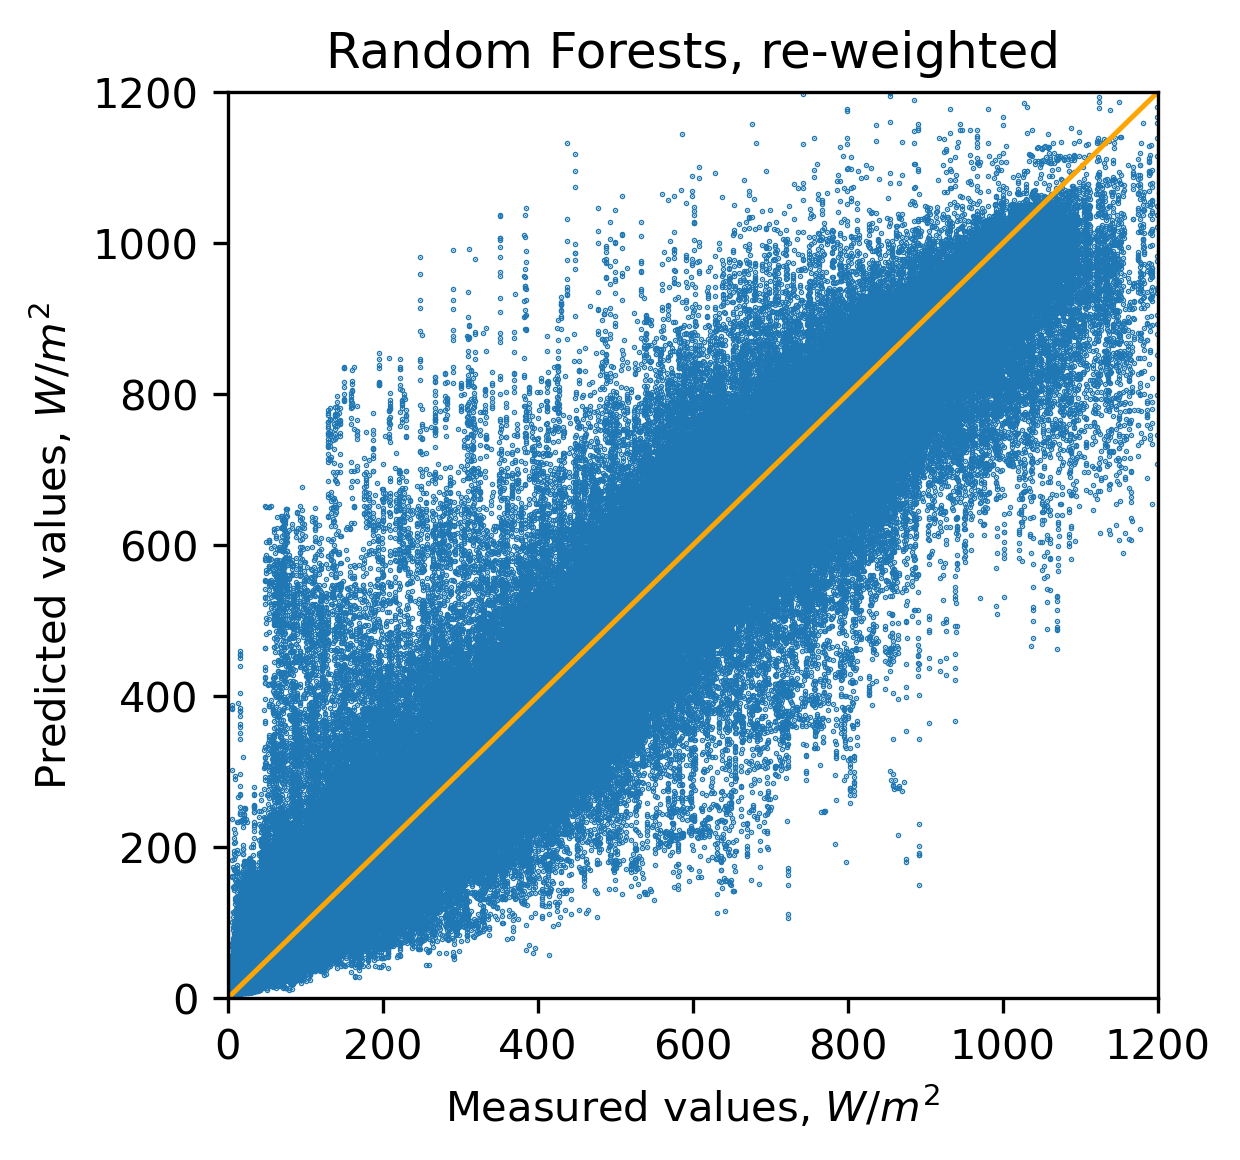

In [145]:
Xtest, ytest = create_Xy(df_test_small)
y_test_array = np.tile(ytest, num_models)



f = plt.figure(figsize=(4,4), dpi=300)
plt.scatter(y_test_array, Ytest_pred_array, s=0.1)
plt.plot([0, 1200], [0, 1200], color="orange", linewidth=1.2)
plt.xlim(0, 1200)
plt.ylim(0, 1200)
plt.title('Random Forests, re-weighted')
plt.xlabel('Measured values, $W/m^2$')
plt.ylabel('Predicted values, $W/m^2$')
plt.savefig('/storage/tartar/mborisov/RFRre-weighted_logs/best_score/RFR_re-weighted.png')


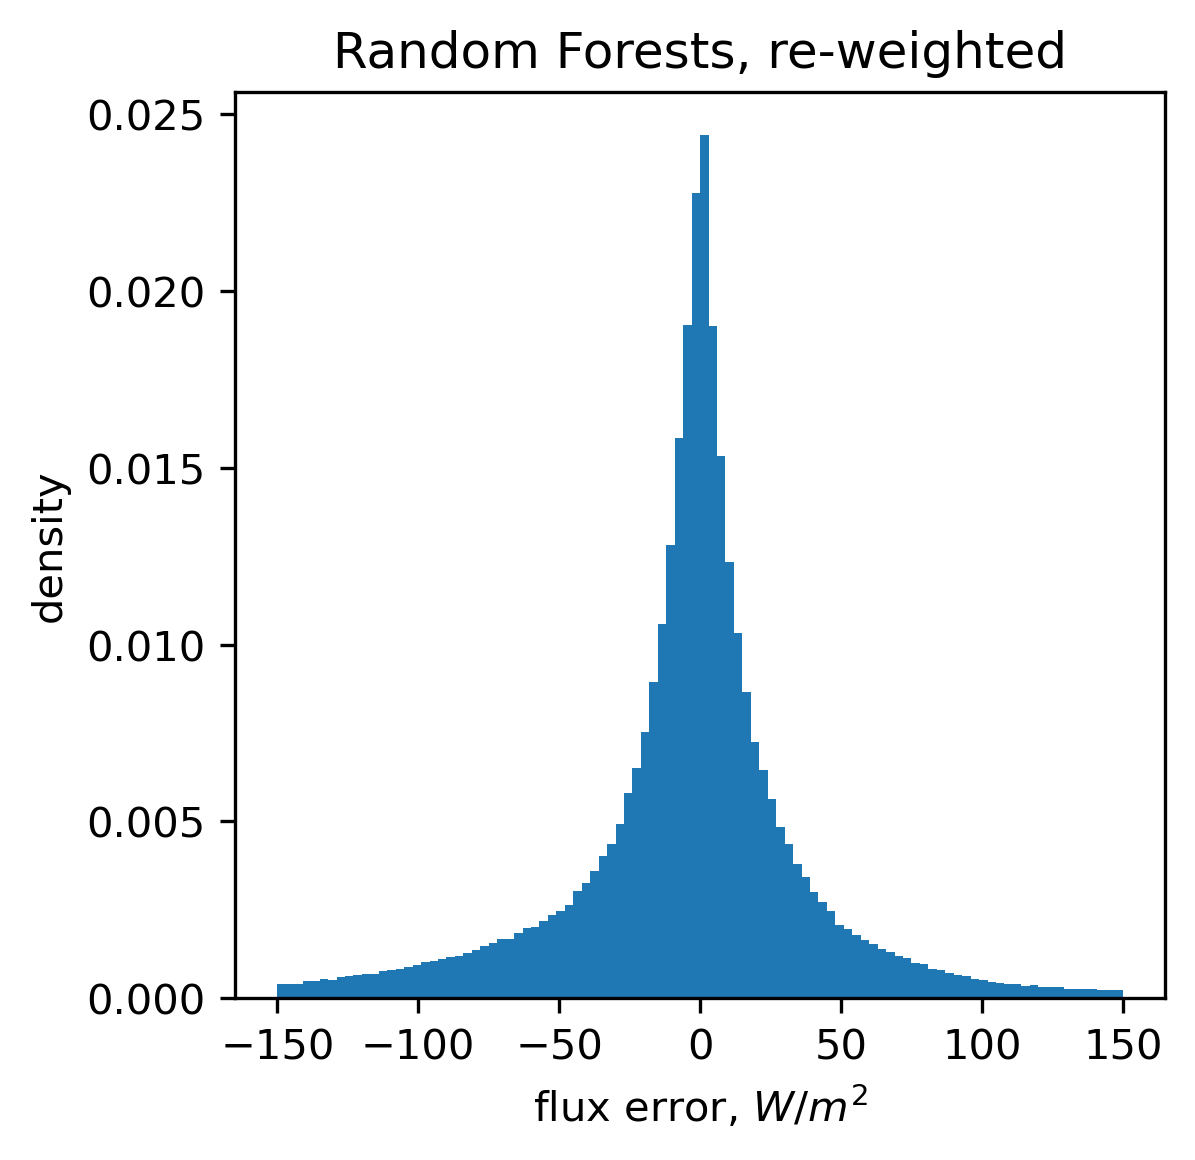

In [146]:
error = (Ytest_pred_array - y_test_array)
filtered = error[(error>-150) & (error<150)] 
f = plt.figure(figsize=(4,4), dpi=300)
plt.hist(filtered, bins = 100, density=True)
# plt.plot([0, 1200], [0, 1200], color="orange", linewidth=1.2)
# plt.xlim(0, 1200)
# plt.ylim(0, 1200)
plt.title('Random Forests, re-weighted')
plt.xlabel('flux error, $W/m^2$')
plt.ylabel('density')
plt.savefig('/storage/tartar/mborisov/RFRre-weighted_logs/best_score/RFR_re-weighted_error_distribution.png')


f = plt.figure(figsize=(4,4), dpi=300)
quantiles_true = np.quantile(y_test_array, np.arange(0, 101, 1)/100)
quantiles_approx = np.quantile(Ytest_pred_array, np.arange(0, 101, 1)/100)
plt.scatter(quantiles_true, quantiles_approx, s=1)
# plt.plot([0, 1200], [0, 1200], color="orange", linewidth=1.2)
plt.xlim(0, 1200)
plt.ylim(0, 1200)
plt.title('Random Forests, re-weighted')
plt.xlabel('Quantiles of measured values, $W/m^2$')
plt.ylabel('Quantiles of approximated values, $W/m^2$')






plt.savefig('/storage/tartar/mborisov/RFRre-weighted_logs/best_score/q-qplot.png')



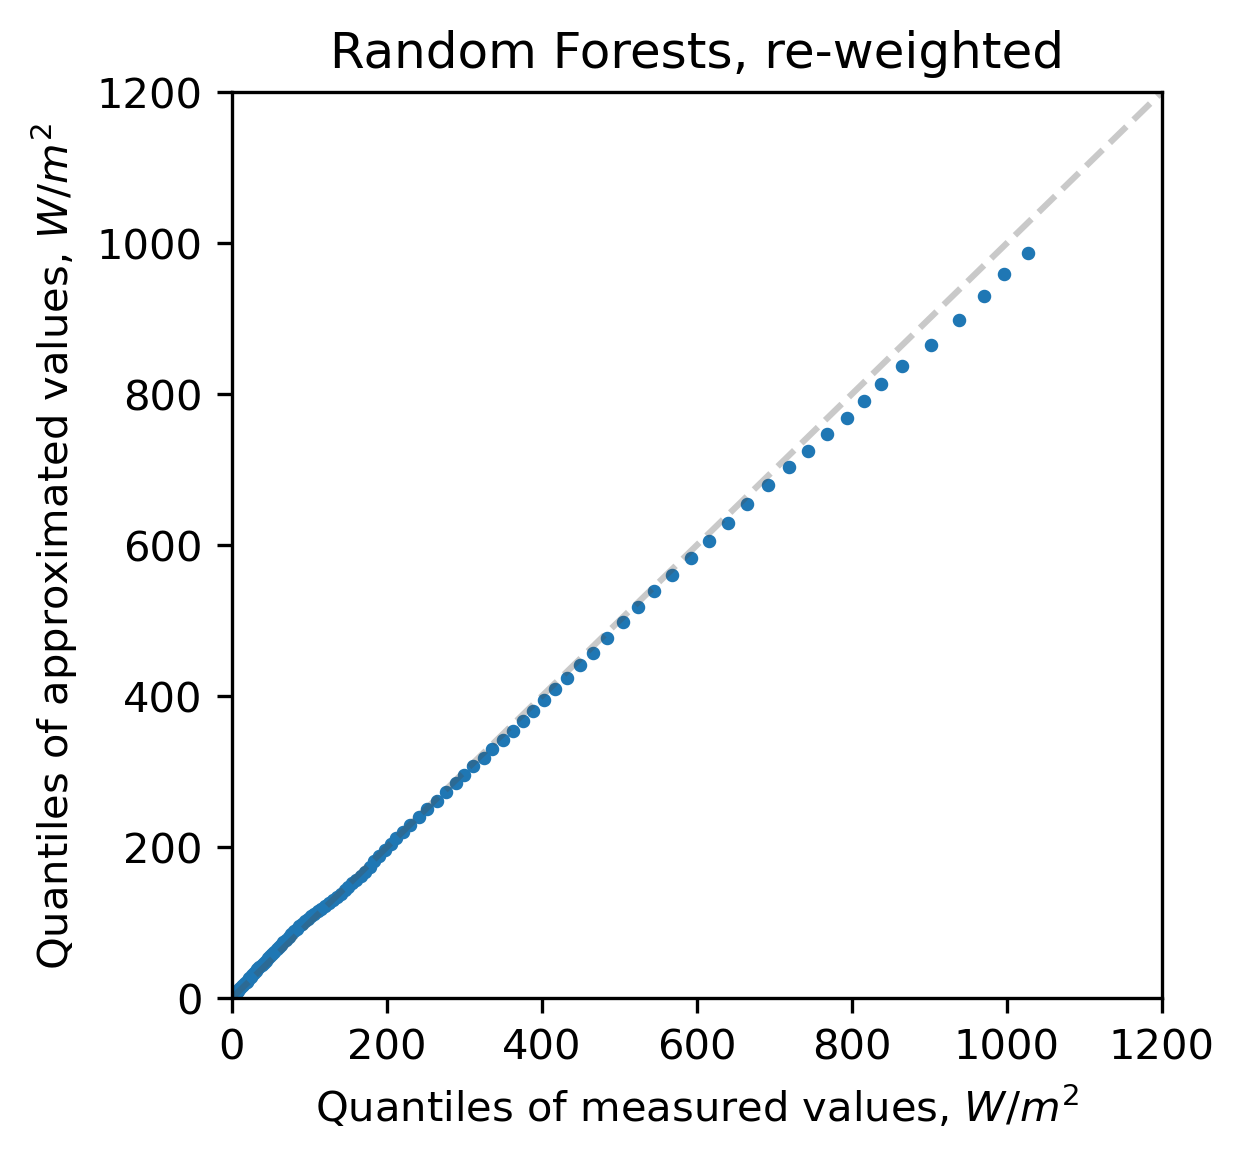

In [192]:
f, ax = plt.subplots(figsize=(4,4), dpi=300)
ax.scatter(quantiles_true, quantiles_approx, s = 5)
ax.plot([0, 1200], [0, 1200], ls="--", c=".3", alpha=0.3)
#ax.set(xlim=(0, 1200), ylim=(0, 1200))
plt.xlim(0, 1200)
plt.ylim(0, 1200)
plt.title('Random Forests, re-weighted')
plt.xlabel('Quantiles of measured values, $W/m^2$')
plt.ylabel('Quantiles of approximated values, $W/m^2$')
plt.savefig('/storage/tartar/mborisov/RFRre-weighted_logs/best_score/q-qplot.png')


In [194]:
num_models = 10
MSE_array = np.array([])
MAE_array = np.array([])
RMSE_array = np.array([])
Ytest_pred_array = np.array([])
df_test_small = df_test[::5]



train_small , shit =   train_test_split(df_train['date_hour'].unique(),
                                       test_size=0.05,
                                       train_size=0.20)
df_train_small = df_train[df_train['date_hour'].isin(train_small)]
Xtr, ytr = create_Xy(df_train_small)
Xtest, ytest = create_Xy(df_test_small)
time_groups = df_train_small['date-hour'].values 

regressor_obj = sklearn.ensemble.RandomForestRegressor(max_depth=28, n_estimators=116, n_jobs = n_jobs)
sample_weight = calculate_weights_with_alfa(ytr, 0.10312353223703095)   
regressor_obj.fit(Xtr, ytr, sample_weight = sample_weight)

scores = cross_val_score(regressor_obj, Xtr, ytr, scoring=metrics.make_scorer(metrics.mean_squared_error), n_jobs=n_jobs,
                     cv = GroupKFold(num_models), groups = time_groups, fit_params={'sample_weight': sample_weight})
final_score = scores.mean()

ytest_pred = regressor_obj.predict(Xtest)   
mse_value = mean_squared_error(ytest_pred, ytest)
mae_value = mean_absolute_error(ytest_pred, ytest)
rmse_value = np.sqrt(mean_squared_error(ytest_pred, ytest))

Ytest_pred_array = np.append(Ytest_pred_array, ytest_pred)   
MSE_array = np.append(MSE_array, mae_value)
MAE_array = np.append(MAE_array, mae_value)
RMSE_array = np.append(RMSE_array, rmse_value)
#joblib.dump(regressor_obj, '/storage/tartar/mborisov/GBRre-weighted_logs/best_score/rfrname' + str(i) + '.pkl', compress=9)


np.save('/storage/tartar/mborisov/RFRre-weighted_logs/best_score/RFRcros_val_predicted_array', Ytest_pred_array)
np.save('/storage/tartar/mborisov/RFRre-weighted_logs/best_score/RFRcros_val_predicted_array', MSE_array)
np.save('/storage/tartar/mborisov/RFRre-weighted_logs/best_score/RFRcros_val_predicted_array', MAE_array)
np.save('/storage/tartar/mborisov/RFRre-weighted_logs/best_score/RFRcros_val_predicted_array', RMSE_array)
np.save('/storage/tartar/mborisov/RFRre-weighted_logs/best_score/RFRcros_val_scores', scores)


In [195]:
scores_rmse = np.sqrt(scores)
print(np.std(scores_rmse)*1.96, scores_rmse.mean())

18.74219395421178 68.48579085639088


# править для бустинга МАЕ и взвешивание

In [ ]:
def objective_gbr(trial):
    gbr_n_estimators = trial.suggest_int('gbr_n_estimators', 100,2000, log=True) # от первого до второго числа перебираем количество деревьев
    gbr_max_depth = trial.suggest_int('gbr_max_depth', 6, 50, log=True) # от первого до второго числа перебираем максимальную глубину
    alfa_interval = trial.suggest_float('alfa', 0.001, 0.999, log = True) # альфа от почти 0 до почти 1
    regressor_obj = xgboost.XGBRegressor(max_depth=gbr_max_depth, n_estimators=950, n_jobs = n_jobs, objective='reg:squarederror')
    train, test = train_test_split(df_full['date_hour'].unique(),
                                       test_size=0.05,
                                       train_size=0.20)
    df_train = df_full[df_full['date_hour'].isin(train)]
    df_test = df_full[df_full['date_hour'].isin(test)]
    Xtr, ytr = create_Xy(df_train)
    Xtest, ytest = create_Xy(df_test)
    sample_weight = calculate_weights_with_alfa(ytr, alfa_interval)
    regressor_obj.fit(Xtr, ytr, sample_weight = sample_weight)
    ytest_pred = regressor_obj.predict(Xtest)
    MAE_value = mean_absolute_error(ytest_pred, ytest)
    if trial.should_prune():
        raise optuna.TrialPruned()
    return MAE_value

In [ ]:
if __name__ == "__main__":
    db_fname = 'Cubrick_predict_sun_swrad.db'
    study_name = 'Workstation_predict_sun_swrad_gbr_ideal_reweight'

    try:
        study = optuna.load_study(study_name=study_name,
                                  storage="sqlite:///%s" % db_fname,
                                  sampler=optuna.samplers.TPESampler())
    except:
        study = optuna.create_study(storage='sqlite:///%s' % db_fname,
                                    study_name=study_name,
                                    sampler=optuna.samplers.TPESampler(),
                                    direction="minimize")

    study.optimize(objective_gbr, n_trials=400, gc_after_trial=True)

In [66]:
def train_func_gbr105(i, mse_array, mae_array, rmse_array, ytest_pred_array):
    train_small , shit =   train_test_split(df_train['date_hour'].unique(),
                                           test_size=0.05,
                                           train_size=0.20)
    df_train_small = df_train[df_train['date_hour'].isin(train_small)]
    Xtr, ytr = create_Xy(df_train_small)
    Xtest, ytest = create_Xy(df_test_small)
    
    regressor_obj = sklearn.ensemble.RandomForestRegressor(max_depth=43, n_estimators=43, n_jobs = n_jobs)
    sample_weight = calculate_weights_with_alfa(ytr, 0.029365061487631388)   
    regressor_obj.fit(Xtr, ytr, sample_weight = sample_weight)
    
    ytest_pred = regressor_obj.predict(Xtest)   
    mse_value = mean_squared_error(ytest_pred, ytest)
    mae_value = mean_absolute_error(ytest_pred, ytest)
    rmse_value = np.sqrt(mean_squared_error(ytest_pred, ytest))
    
    ytest_pred_array = np.append(ytest_pred_array, ytest_pred)   
    mse_array = np.append(mse_array, mae_value)
    mae_array = np.append(mae_array, mae_value)
    rmse_array = np.append(rmse_array, rmse_value)

    
    np.save('/storage/tartar/mborisov/RFRre-weighted_logs/105try/RFR_predicted_array', ytest_pred_array)
    np.save('/storage/tartar/mborisov/RFRre-weighted_logs/105try/RFR_MSE_array', mse_array)
    np.save('/storage/tartar/mborisov/RFRre-weighted_logs/105try/RFR_MAE_array', mae_array)
    np.save('/storage/tartar/mborisov/RFRre-weighted_logs/105try/RFR_RMSE_array', rmse_array)
    joblib.dump(regressor_obj, '/storage/tartar/mborisov/RFRre-weighted_logs/105try/rfrname' + str(i) + '.pkl', compress=9)
num_models = 10
MSE_array = np.array([])
MAE_array = np.array([])
RMSE_array = np.array([])
Ytest_pred_array = np.array([])
df_test_small = df_test[::5]

In [ ]:
for i in range(num_models):
    train_func_gbr105(i, MSE_array, MAE_array, RMSE_array, Ytest_pred_array)
    print(i)

0


In [83]:
num_models = 10
MSE_array = np.array([])
MAE_array = np.array([])
RMSE_array = np.array([])
Ytest_pred_array = np.array([])
df_test_small = df_test[::5]
for i in range(num_models):
    joblib_model = joblib.load('/storage/tartar/mborisov/RFRre-weighted_logs/best_score/rfrname' + str(i) + '.pkl') 
    ytest_pred = joblib_model.predict(Xtest)
    mse_value = mean_squared_error(ytest_pred, ytest)
    mae_value = mean_absolute_error(ytest_pred, ytest)
    rmse_value = np.sqrt(mean_squared_error(ytest_pred, ytest))
    
    Ytest_pred_array = np.append(Ytest_pred_array, ytest_pred)   
    MSE_array = np.append(MSE_array, mae_value)
    MAE_array = np.append(MAE_array, mse_value)
    RMSE_array = np.append(RMSE_array, rmse_value)
    print(i)
np.save('/storage/tartar/mborisov/RFRre-weighted_logs/best_score/RFR_predicted_array', Ytest_pred_array)
np.save('/storage/tartar/mborisov/RFRre-weighted_logs/best_score/RFR_MSE_array', mse_array)
np.save('/storage/tartar/mborisov/RFRre-weighted_logs/best_score/RFR_MAE_array', mae_array)
np.save('/storage/tartar/mborisov/RFRre-weighted_logs/105try/RFR_RMSE_array', RMSE_array)

KeyboardInterrupt: 

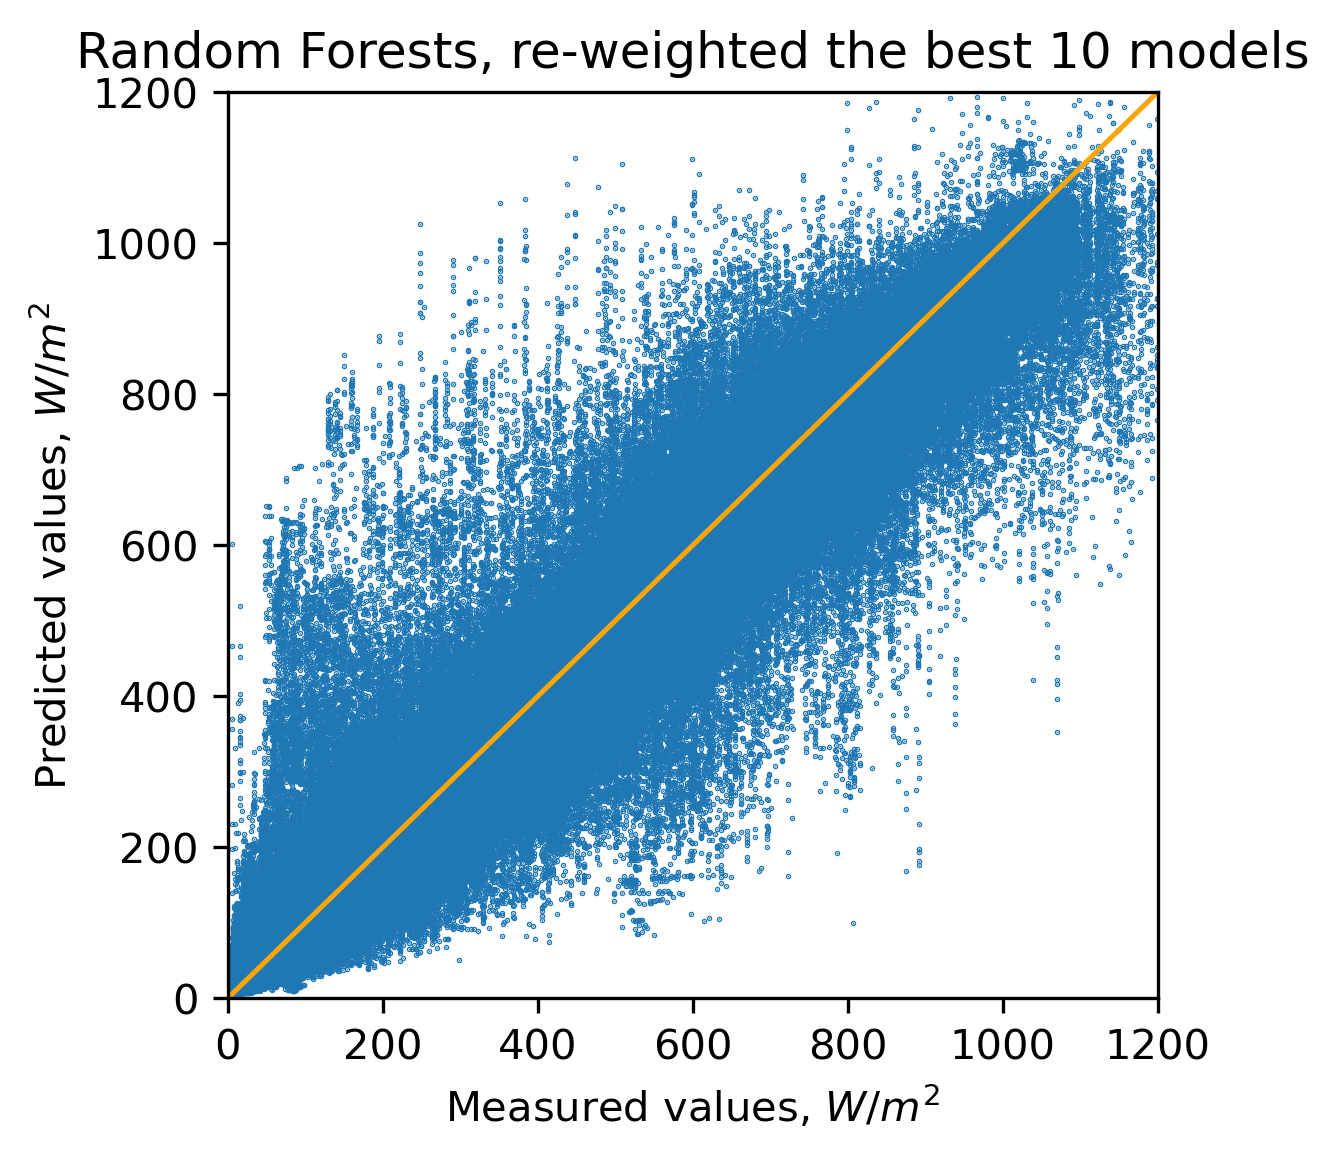

In [73]:
Xtest, ytest = create_Xy(df_test_small)
y_test_array = np.tile(ytest, num_models)



f = plt.figure(figsize=(4,4), dpi=300)
plt.scatter(y_test_array, Ytest_pred_array, s=0.1)
plt.plot([0, 1200], [0, 1200], color="orange", linewidth=1.2)
plt.xlim(0, 1200)
plt.ylim(0, 1200)
plt.title('Random Forests, re-weighted the best 10 models')
plt.xlabel('Measured values, $W/m^2$')
plt.ylabel('Predicted values, $W/m^2$')
plt.savefig('/storage/tartar/mborisov/RFRre-weighted_logs/105try/RFR_re-weighted.png')


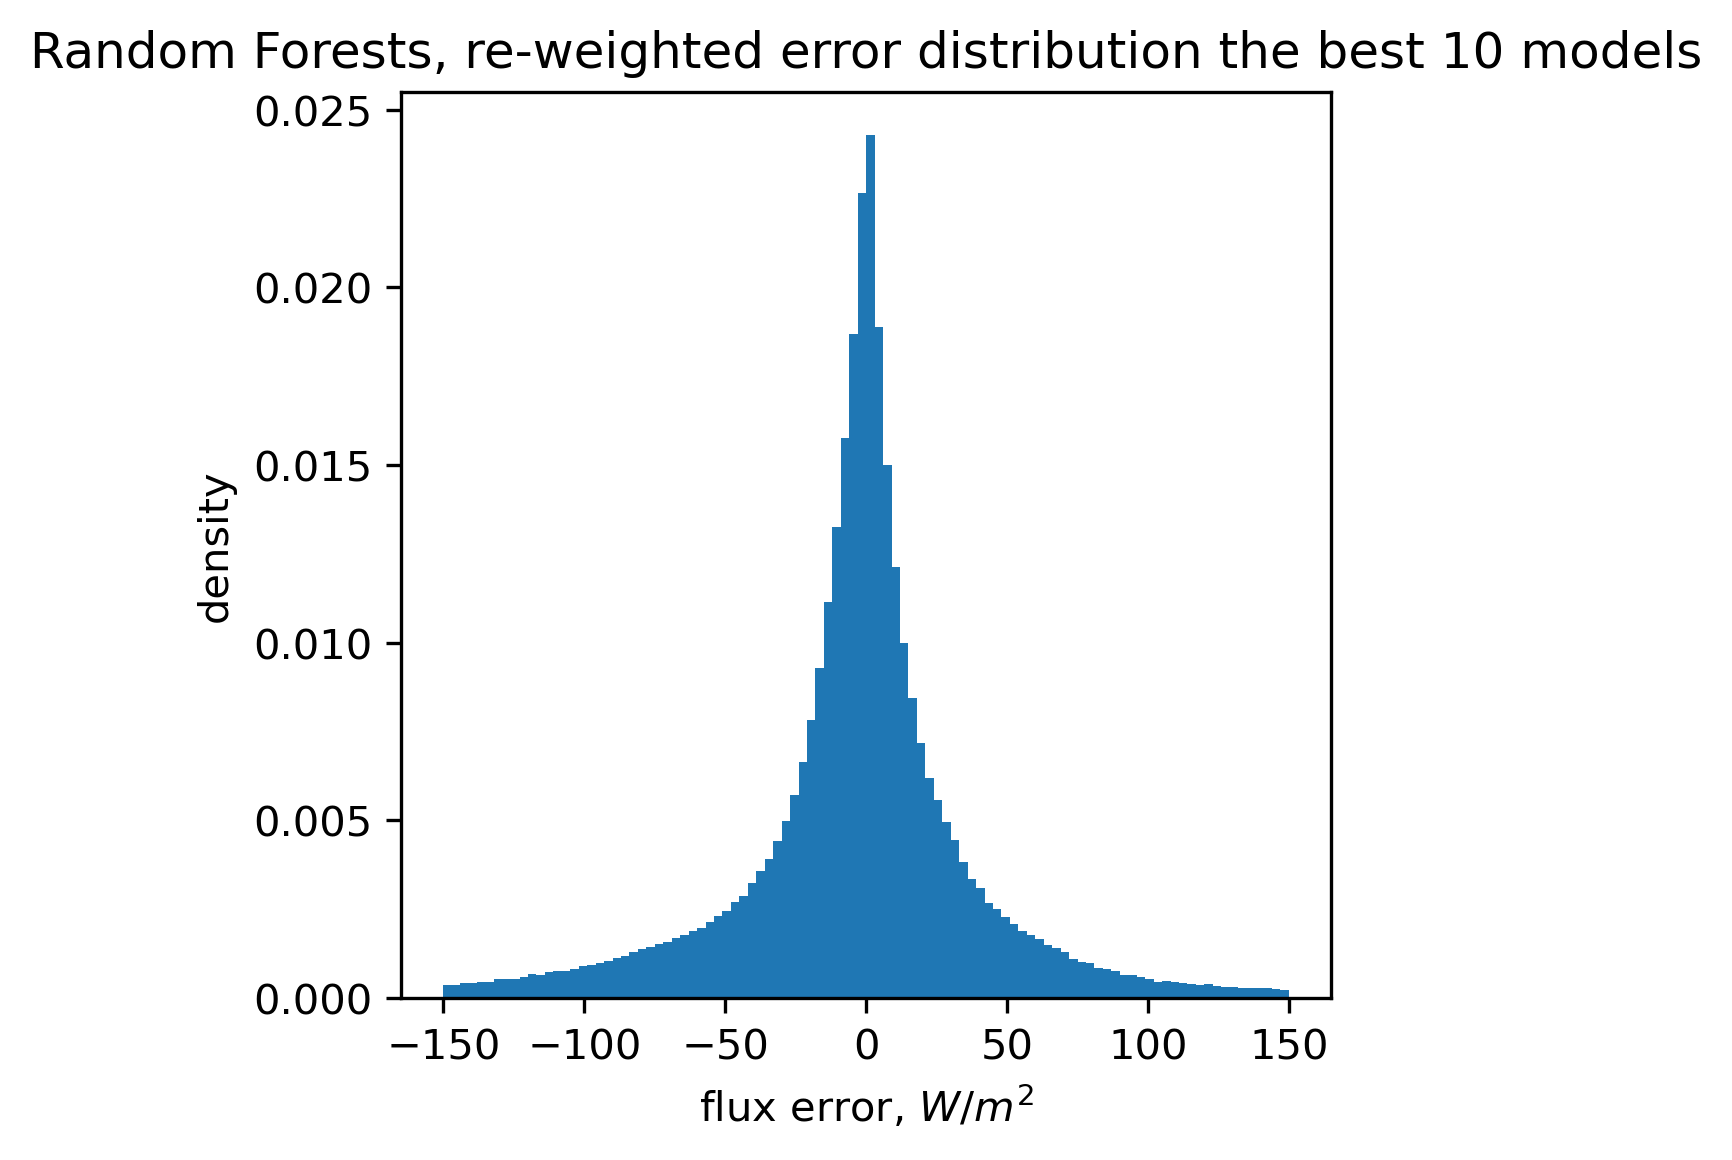

In [74]:
error = (Ytest_pred_array - y_test_array)
filtered = error[(error>-150) & (error<150)] 
f = plt.figure(figsize=(4,4), dpi=300)
plt.hist(filtered, bins = 100, density=True)
# plt.plot([0, 1200], [0, 1200], color="orange", linewidth=1.2)
# plt.xlim(0, 1200)
# plt.ylim(0, 1200)
plt.title('Random Forests, re-weighted error distribution the best 10 models')
plt.xlabel('flux error, $W/m^2$')
plt.ylabel('density')
plt.savefig('/storage/tartar/mborisov/RFRre-weighted_logs/105try/RFR_re-weighted_error_distribution.png')


In [86]:
def train_func_gbr36(i, mse_array, mae_array, rmse_array, ytest_pred_array):
    train_small , shit =   train_test_split(df_train['date_hour'].unique(),
                                           test_size=0.05,
                                           train_size=0.20)
    df_train_small = df_train[df_train['date_hour'].isin(train_small)]
    Xtr, ytr = create_Xy(df_train_small)
    Xtest, ytest = create_Xy(df_test_small)
    
    regressor_obj = sklearn.ensemble.RandomForestRegressor(max_depth=491, n_estimators=579, n_jobs = n_jobs)
    sample_weight = calculate_weights_with_alfa(ytr, 0.0016093498111690427)   
    regressor_obj.fit(Xtr, ytr, sample_weight = sample_weight)
    
    ytest_pred = regressor_obj.predict(Xtest)   
    mse_value = mean_squared_error(ytest_pred, ytest)
    mae_value = mean_absolute_error(ytest_pred, ytest)
    rmse_value = np.sqrt(mean_squared_error(ytest_pred, ytest))
    
    ytest_pred_array = np.append(ytest_pred_array, ytest_pred)   
    mse_array = np.append(mse_array, mse_value)
    mae_array = np.append(mae_array, mae_value)
    rmse_array = np.append(rmse_array, rmse_value)

    
    np.save('/storage/tartar/mborisov/RFRre-weighted_logs/36try/RFR_predicted_array', ytest_pred_array)
    np.save('/storage/tartar/mborisov/RFRre-weighted_logs/36try/RFR_MSE_array', mse_array)
    np.save('/storage/tartar/mborisov/RFRre-weighted_logs/36try/RFR_MAE_array', mae_array)
    np.save('/storage/tartar/mborisov/RFRre-weighted_logs/36try/RFR_RMSE_array', rmse_array)
    joblib.dump(regressor_obj, '/storage/tartar/mborisov/RFRre-weighted_logs/36try/rfrname' + str(i) + '.pkl', compress=9)
num_models = 10
MSE_array = np.array([])
MAE_array = np.array([])
RMSE_array = np.array([])
Ytest_pred_array = np.array([])
df_test_small = df_test[::5]

In [87]:
for i in range(num_models):
    train_func_gbr36(i, MSE_array, MAE_array, RMSE_array, Ytest_pred_array)
    print(i)

KeyboardInterrupt: 

In [ ]:
num_models = 10
MSE_array = np.array([])
MAE_array = np.array([])
RMSE_array = np.array([])
Ytest_pred_array = np.array([])
df_test_small = df_test[::5]
for i in range(num_models):
    joblib_model = joblib.load('/storage/tartar/mborisov/RFRre-weighted_logs/36try/rfrname' + str(i) + '.pkl') 
    ytest_pred = joblib_model.predict(Xtest)
    mse_value = mean_squared_error(ytest_pred, ytest)
    mae_value = mean_absolute_error(ytest_pred, ytest)
    rmse_value = np.sqrt(mean_squared_error(ytest_pred, ytest))
    
    Ytest_pred_array = np.append(Ytest_pred_array, ytest_pred)   
    MSE_array = np.append(MSE_array, mae_value)
    MAE_array = np.append(MAE_array, mse_value)
    RMSE_array = np.append(RMSE_array, rmse_value)
    print(i)
np.save('/storage/tartar/mborisov/RFRre-weighted_logs/36try/RFR_predicted_array', Ytest_pred_array)
np.save('/storage/tartar/mborisov/RFRre-weighted_logs/36try/RFR_MSE_array', mse_array)
np.save('/storage/tartar/mborisov/RFRre-weighted_logs/36try/RFR_MAE_array', mae_array)
np.save('/storage/tartar/mborisov/RFRre-weighted_logs/36try/RFR_RMSE_array', RMSE_array)

In [ ]:
Xtest, ytest = create_Xy(df_test_small)
y_test_array = np.tile(ytest, num_models)



f = plt.figure(figsize=(4,4), dpi=300)
plt.scatter(y_test_array, Ytest_pred_array, s=0.1)
plt.plot([0, 1200], [0, 1200], color="orange", linewidth=1.2)
plt.xlim(0, 1200)
plt.ylim(0, 1200)
plt.title('Random Forests, re-weighted the best 10 models')
plt.xlabel('Measured values, $W/m^2$')
plt.ylabel('Predicted values, $W/m^2$')
plt.savefig('/storage/tartar/mborisov/RFRre-weighted_logs/36try/RFR_re-weighted.png')

In [ ]:
error = (Ytest_pred_array - y_test_array)
filtered = error[(error>-150) & (error<150)] 
f = plt.figure(figsize=(4,4), dpi=300)
plt.hist(filtered, bins = 100, density=True)
# plt.plot([0, 1200], [0, 1200], color="orange", linewidth=1.2)
# plt.xlim(0, 1200)
# plt.ylim(0, 1200)
plt.title('Random Forests, re-weighted error distribution the best 10 models')
plt.xlabel('flux error, $W/m^2$')
plt.ylabel('density')
plt.savefig('/storage/tartar/mborisov/RFRre-weighted_logs/36try/RFR_re-weighted_error_distribution.png')


In [45]:
for i in range(num_models):
    joblib_model = joblib.load('/storage/tartar/mborisov/RFRre-weighted_logs/265try/rfrname' + str(i) + '.pkl') 
    ytest_pred = joblib_model.predict(Xtest)
    mse_value = mean_squared_error(ytest_pred, ytest)
    mae_value = mean_absolute_error(ytest_pred, ytest)
    rmse_value = np.sqrt(mean_squared_error(ytest_pred, ytest))
    
    ytest_pred_array = np.append(ytest_pred_array, ytest_pred)   
    MSE_array = np.append(MSE_array, mae_value)
    MAE_array = np.append(MAE_array, mae_value)
    RMSE_array = np.append(RMSE_array, rmse_value)
    print(i)

0
1
2
3
4
5
6
7
8
9


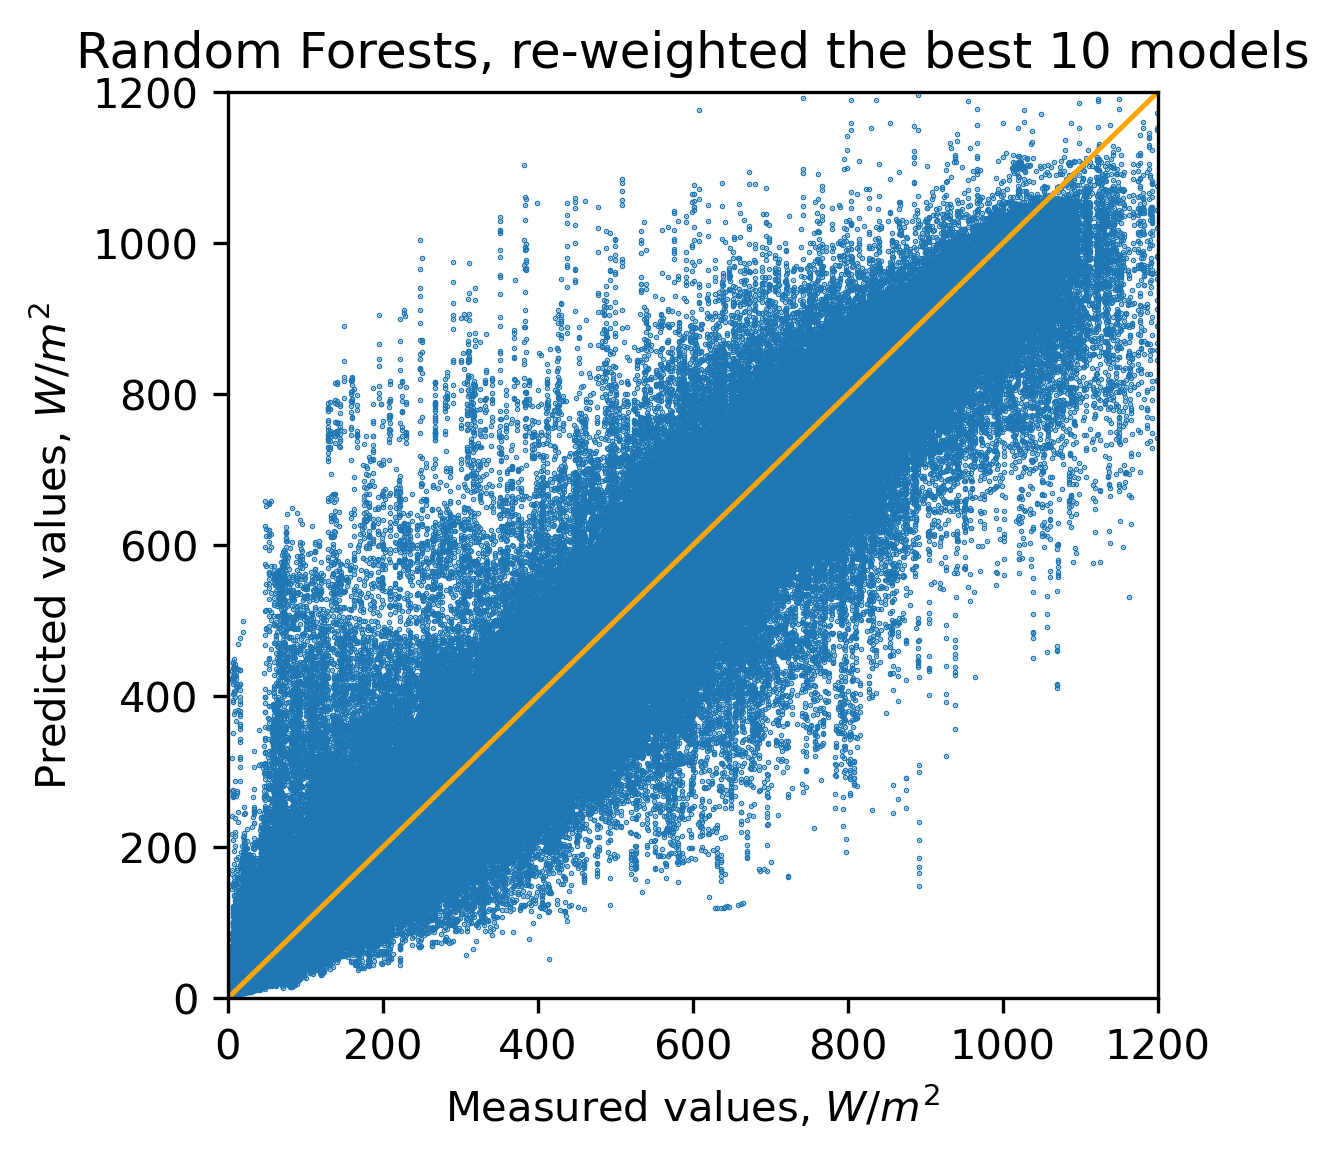

In [46]:
Xtest, ytest = create_Xy(df_test_small)
y_test_array = np.tile(ytest, num_models)



f = plt.figure(figsize=(4,4), dpi=300)
plt.scatter(y_test_array, ytest_pred_array, s=0.1)
plt.plot([0, 1200], [0, 1200], color="orange", linewidth=1.2)
plt.xlim(0, 1200)
plt.ylim(0, 1200)
plt.title('Random Forests, re-weighted the best 10 models')
plt.xlabel('Measured values, $W/m^2$')
plt.ylabel('Predicted values, $W/m^2$')
plt.savefig('/storage/tartar/mborisov/RFRre-weighted_logs/265try/RFR_re-weighted.png')


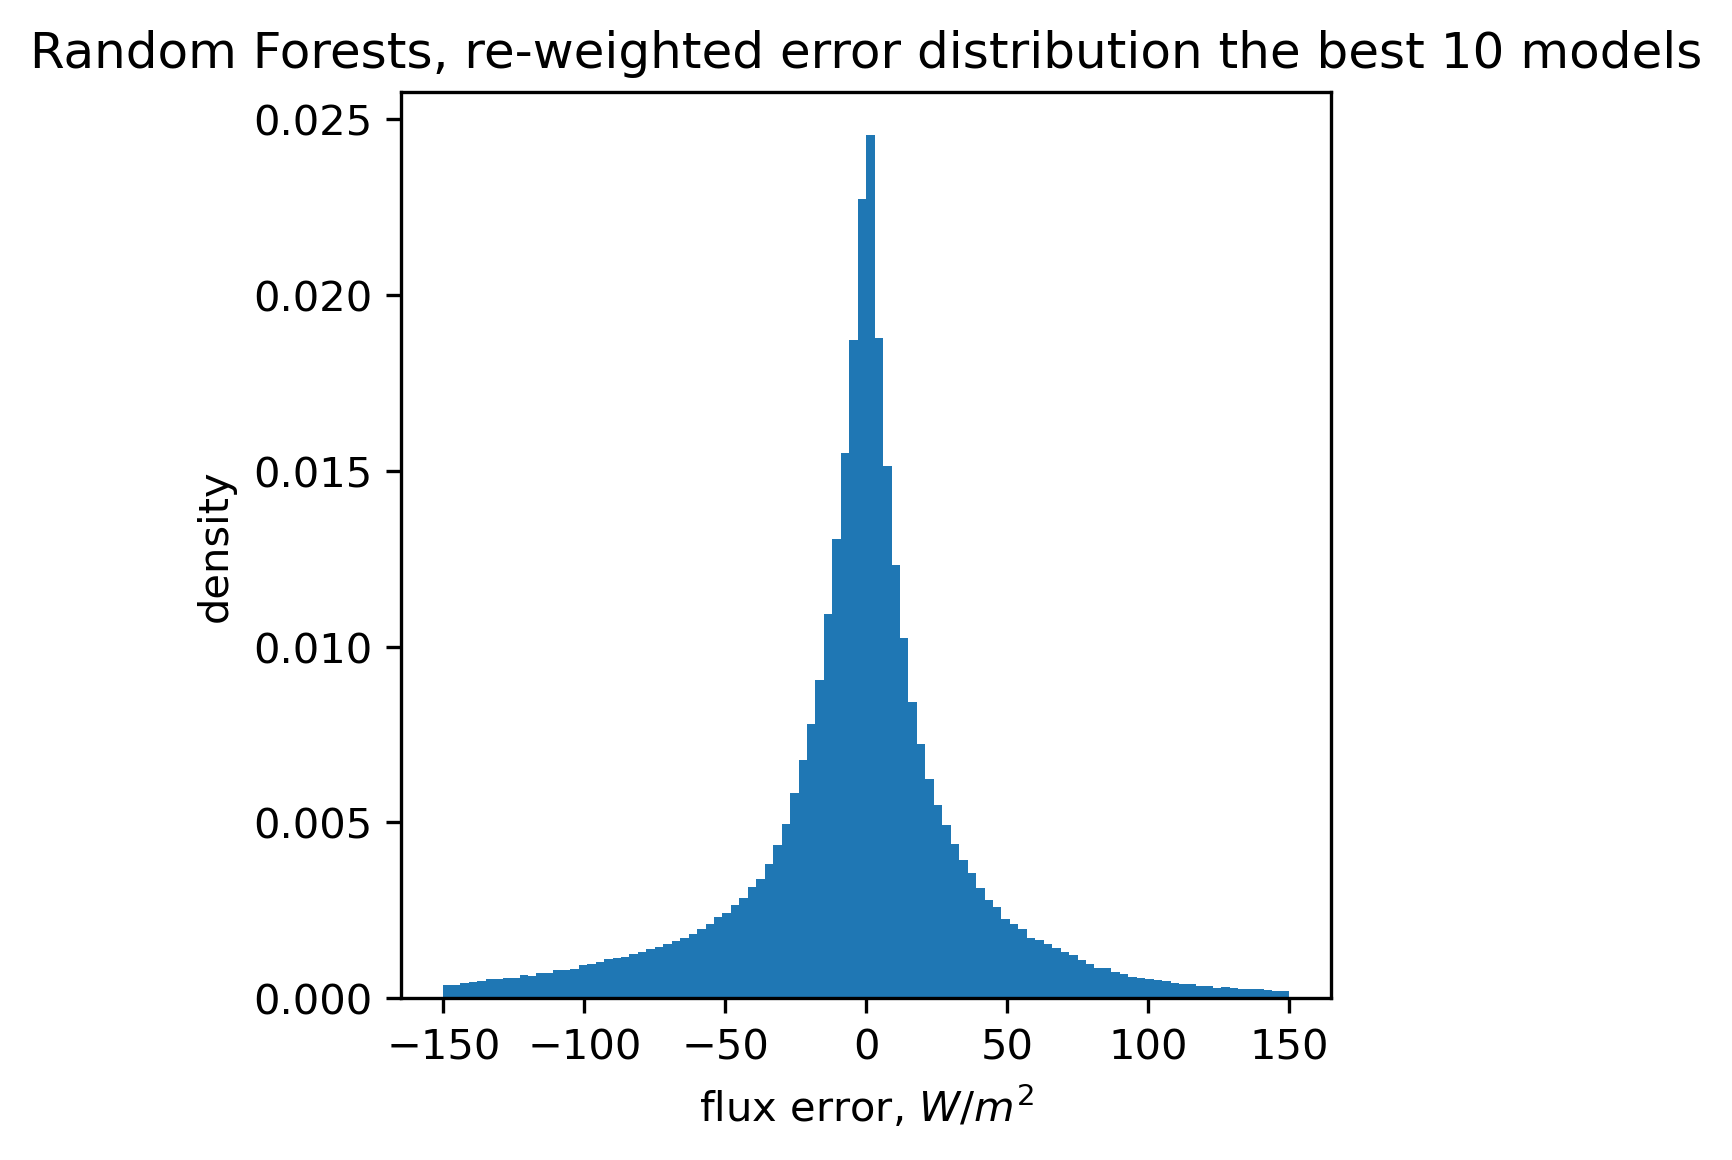

In [47]:
error = (ytest_pred_array - y_test_array)
filtered = error[(error>-150) & (error<150)] 
f = plt.figure(figsize=(4,4), dpi=300)
plt.hist(filtered, bins = 100, density=True)
# plt.plot([0, 1200], [0, 1200], color="orange", linewidth=1.2)
# plt.xlim(0, 1200)
# plt.ylim(0, 1200)
plt.title('Random Forests, re-weighted error distribution the best 10 models')
plt.xlabel('flux error, $W/m^2$')
plt.ylabel('density')
plt.savefig('/storage/tartar/mborisov/RFRre-weighted_logs/265try/RFR_re-weighted_error_distribution.png')


In [ ]:
def train_func_rfr(i, MAE_array, ytest_pred_array):
    train_small , shit =   train_test_split(df_train['date_hour'].unique(),
                                           test_size=0.05,
                                           train_size=0.20)
    df_train_small = df_train[df_train['date_hour'].isin(train_small)]
    Xtr, ytr = create_Xy(df_train_small)
    Xtest, ytest = create_Xy(df_test_small)
    ###### тут параметры леса и альфа
    
    
    regressor_obj = model = RandomForestRegressor()
    sample_weight = calculate_weights_with_alfa(ytr, ALFA)

    ######
    
    regressor_obj.fit(Xtr, ytr, sample_weight = sample_weight)
    ytest_pred = regressor_obj.predict(Xtest)
    ytest_pred_array = np.append(ytest_pred_array,ytest_pred)
    mae_value = (mean_absolute_error(ytest_pred, ytest))
    mae_array = np.append(MAE_array,mae_value)
    #pickle.dump(model,open('try nombertuple_model'+ str(i) + '.pkl”', 'wb'))
    np.save('RFR_predicted_array', ytest_pred_array)
    np.save('RFR_MAE_array', mae_array)
    joblib.dump(regressor_obj, "RFRfname.pkl"+ str(i) + '.pkl', compress=9)


In [ ]:
num_models = 10
ytest_pred_array = np.array([])
mae_array = np.array([])

In [ ]:

for i in range(num_models):
    train_func_rfr(i, mae_array, ytest_pred_array)
    print(i)

In [ ]:
Xtest, ytest = create_Xy(df_test_small)
y_test_array = np.tile(ytest, num_models)



f = plt.figure(figsize=(4,4), dpi=300)
plt.scatter(y_test_array, ytest_pred_array, s=0.1)
plt.plot([0, 1200], [0, 1200], color="orange", linewidth=1.2)
plt.xlim(0, 1200)
plt.ylim(0, 1200)
plt.title('RandomForestRegressor the best 10 models')
plt.xlabel('Measured values, $W/m^2$')
plt.ylabel('Predicted values, $W/m^2$')

In [ ]:
error = (ytest_pred_array - y_test_array)
filtered = error[(error>-150) & (error<150)] 
f = plt.figure(figsize=(4,4), dpi=300)
plt.hist(filtered, bins = 100, density=True)
# plt.plot([0, 1200], [0, 1200], color="orange", linewidth=1.2)
# plt.xlim(0, 1200)
# plt.ylim(0, 1200)
plt.title('RandomForestRegressor error distribution the best 10 models')
plt.xlabel('flux error, $W/m^2$')
plt.ylabGradient boosting regressorel('density')

# Так загружать

In [ ]:
for i in range(10):
    joblib_model = joblib.load("fname.pkl"+ str(i) + '.pkl') 
    ytest_pred = joblib_model.predict(Xtest)
    rmse_value = np.sqrt(mean_squared_error(ytest_pred, ytest))
    rmse_array = np.append(rmse_array,rmse_value)

In [ ]:
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

# some time later...

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)


for i in range(10):
    train_func(i,rmse_array)
    print(i)

In [ ]:
rmse_array = np.array(())
Xtest, ytest = create_Xy(df_test_small)

In [ ]:
y_test_array_pred = np.array([])
y_test_array = np.array([])

In [ ]:
for i in range (10):
    joblib_model = joblib.load("fname.pkl"+ str(i) + '.pkl')
    ytest_pred = joblib_model.predict(Xtest)
    rmse_value = np.sqrt(mean_squared_error(ytest_pred, ytest))
    rmse_array = np.append(rmse_array,rmse_value)
    y_test_array_pred = np.append(y_test_array_pred, ytest_pred)
    y_test_array = np.append(y_test_array, ytest)

In [ ]:
f = plt.figure(figsize=(4,4), dpi=300)
plt.scatter(y_test_array, y_test_array_pred, s=0.1)
plt.plot([0, 1200], [0, 1200], color="orange", linewidth=1.2)
plt.xlim(0, 1200)
plt.ylim(0, 1200)
plt.title('RandomForestRegressor the best 10 models')
plt.xlabel('Measured values, $W/m^2$')
plt.ylabel('Predicted values, $W/m^2$')

In [ ]:
error = (y_test_array_pred - y_test_array)
filtered = error[(error>-150) & (error<150)] 
f = plt.figure(figsize=(4,4), dpi=300)
plt.hist(filtered, bins = 100, density=True)
# plt.plot([0, 1200], [0, 1200], color="orange", linewidth=1.2)
# plt.xlim(0, 1200)
# plt.ylim(0, 1200)
plt.title('RandomForestRegressor error distribution the best 10 models')
plt.xlabel('flux error, $W/m^2$')
plt.ylabel('density')

In [ ]:
    ytest, ytest_pred

In [ ]:
rmse_array

In [ ]:
rmse_array = rmse_array[1:].copy

In [ ]:
rmse_array

In [ ]:
rmse_array

In [ ]:
rmse_array

In [ ]:
rmse_array = rmse_array[1:]

In [ ]:
np.mean(rmse_array), np.std(rmse_array)*1.96

In [ ]:
ytest_pred

In [ ]:
joblib_model = joblib.load('fname.pkl0.pkl') 
ytest_pred = joblib_model.predict(Xtest)


In [ ]:
joblib_model.score(ytest_pred, ytest)

In [ ]:
f = plt.figure(figsize=(4,4), dpi=300)
plt.scatter(ytest, ytest_pred, s=0.1)
plt.plot([0, 1200], [0, 1200], color="orange", linewidth=1.2)
plt.xlim(0, 1200)
plt.ylim(0, 1200)
plt.title('RandomForestRegressor')
plt.xlabel('Measured values, $W/m^2$')
plt.ylabel('Predicted values, $W/m^2$')

In [ ]:
df_full = pd.concat((df_train, df_test))
df_full['date_hour'] = pd.to_datetime(df_full['photo_datetime'].dt.date) + \
           pd.to_timedelta(df_full['photo_datetime'].dt.hour, unit='hours')
df_full.head()

In [ ]:
def create_Xy(df_train):
    feature_columns = [c for c in df_train.columns if c.startswith('f') or c=='sin_sun']    
    ytr = df_train['CM3up[W/m2]'].values
    Xtr = df_train[feature_columns].values
    #print('dataset_features: ' + str(Xtr.shape) + ', target: ' + str(ytr.shape))
    return Xtr, ytr

In [ ]:
Xtr, ytr = create_Xy(df_train)
Xtest, ytest = create_Xy(df_test)

In [ ]:
model = RandomForestRegressor(n_estimators=289, n_jobs=20, max_depth=32)
_ = model.fit(Xtr, ytr)

In [ ]:
ytest_pred = model.predict(Xtest)
rmse_value = np.sqrt(mean_squared_error(ytest_pred, ytest))

In [ ]:
error = (ytest_pred - ytest)

In [ ]:
filtered = error[(error>-150) & (error<150)] 
f = plt.figure(figsize=(4,4), dpi=300)
plt.hist(filtered, bins = 100, density=True)
# plt.plot([0, 1200], [0, 1200], color="orange", linewidth=1.2)
# plt.xlim(0, 1200)
# plt.ylim(0, 1200)
plt.title('RandomForestRegressor error distribution')
plt.xlabel('flux error, $W/m^2$')
plt.ylabel('density')

model_GB = GradientBoostingRegressor(n_estimators=500, max_depth=10)

In [ ]:
# договорились на 20
n_jobs=20

In [ ]:
# 1. Define an objective function to be maximized.
def objective(trial):
    # 2. Suggest values for the hyperparameters using a trial object.
    rfr_n_estimators = trial.suggest_int('rfr_n_estimators', 100,1000, log=True) # от первого до второго числа перебираем количество деревьев
    rfr_max_depth = trial.suggest_int('rfr_max_depth', 20, 500, log=True) # от первого до второго числа перебираем максимальную глубину 
    regressor_obj = sklearn.ensemble.RandomForestRegressor(max_depth=rfr_max_depth, n_estimators=rfr_n_estimators, n_jobs = n_jobs)
    train, test = train_test_split(df_full['date_hour'].unique(),
                                       test_size=0.05,
                                       train_size=0.20)
    df_train = df_full[df_full['date_hour'].isin(train)]
    df_test = df_full[df_full['date_hour'].isin(test)]
    Xtr, ytr = create_Xy(df_train)
    Xtest, ytest = create_Xy(df_test)
    regressor_obj.fit(Xtr, ytr)
    ytest_pred = regressor_obj.predict(Xtest)
    rmse_value = np.sqrt(mean_squared_error(ytest_pred, ytest))
    if trial.should_prune():
        raise optuna.TrialPruned()
    return rmse_value

In [ ]:
# 1. Define an objective function to be maximized.
def train(i):
    # 2. Suggest values for the hyperparameters using a trial object.
    regressor_obj = sklearn.ensemble.RandomForestRegressor(max_depth=32, n_estimators=289, n_jobs = n_jobs)
    train, test = train_test_split(df_full['date_hour'].unique(),
                                       test_size=0.05,
                                       train_size=0.20)
    df_train = df_full[df_full['date_hour'].isin(train)]
    df_test = df_full[df_full['date_hour'].isin(test)]
    Xtr, ytr = create_Xy(df_train)
    Xtest, ytest = create_Xy(df_test)
    regressor_obj.fit(Xtr, ytr)
    ytest_pred = regressor_obj.predict(Xtest)
    rmse_value = np.sqrt(mean_squared_error(ytest_pred, ytest))
    if trial.should_prune():
        raise optuna.TrialPruned()
    return rmse_value

In [ ]:
if __name__ == "__main__":
    #err_fname = './logs/hpo_richards_gamma.err'
    db_fname = 'Cubrick_predict_sun_swrad.db'
    study_name = 'Cubrick_predict_sun_swrad'

    try:
        study = optuna.load_study(study_name=study_name,
                                  storage="sqlite:///%s" % db_fname,
                                  sampler=optuna.samplers.TPESampler())
    except:
        study = optuna.create_study(storage='sqlite:///%s' % db_fname,
                                    study_name=study_name,
                                    sampler=optuna.samplers.TPESampler(),
                                    direction="minimize")

    study.optimize(objective, n_trials=100, gc_after_trial=True)

In [ ]:
model = GradientBoostingRegressor(n_estimators=500, max_depth=10)


In [ ]:
# 1. Define an objective function to be maximized.
def objective(trial):
    # 2. Suggest values for the hyperparameters using a trial object.
    rfr_n_estimators = trial.suggest_int('rfr_n_estimators', 100,2000, log=True) # от первого до второго числа перебираем количество деревьев
    rfr_max_depth = trial.suggest_int('rfr_max_depth', 10, 40, log=True) # от первого до второго числа перебираем максимальную глубину 
    regressor_obj = sklearn.ensemble.GradientBoostingRegressor(max_depth=rfr_max_depth, n_estimators=rfr_n_estimators)
    train, test = train_test_split(df_full['date_hour'].unique(),
                                       test_size=0.05,
                                       train_size=0.20)
    df_train = df_full[df_full['date_hour'].isin(train)]
    df_test = df_full[df_full['date_hour'].isin(test)]
    Xtr, ytr = create_Xy(df_train)
    Xtest, ytest = create_Xy(df_test)
    regressor_obj.fit(Xtr, ytr)
    ytest_pred = regressor_obj.predict(Xtest)
    rmse_value = np.sqrt(mean_squared_error(ytest_pred, ytest))
    if trial.should_prune():
        raise optuna.TrialPruned()
    return rmse_value

In [ ]:
if __name__ == "__main__":
    #err_fname = './logs/hpo_richards_gamma.err'
    db_fname = 'Cubrick_predict_sun_swrad_grad_bust.db'
    study_name = 'Cubrick_predict_sun_swrad_grad_bust'

    try:
        study = optuna.load_study(study_name=study_name,
                                  storage="sqlite:///%s" % db_fname,
                                  sampler=optuna.samplers.TPESampler())
    except:
        study = optuna.create_study(storage='sqlite:///%s' % db_fname,
                                    study_name=study_name,
                                    sampler=optuna.samplers.TPESampler(),
                                    direction="minimize")

    study.optimize(objective, n_trials=100, gc_after_trial=True)